# Black scholes vs Monte Carlo for option pricing

In [25]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

## Black-Scholes Equation for call options



$C(S, t) = N(d_1)S - N(d_2)Ke^{-r(T-t)}$

where:

$d_1 = \frac{\ln(S/K) + \left(r + \frac{\sigma^2}{2}\right)(T - t)}{\sigma \sqrt{T - t}}$

$d_2 = d_1 - \sigma \sqrt{T - t}$


### Variables in the Black-Scholes Equation

- $C(S, t)$: The price of the call option at time $t$, given the stock price $S$.
- $S$: The current price of the underlying stock.
- $K$: The strike price of the option, i.e., the price at which the option can be exercised.
- $T$: The time to maturity of the option, expressed in years.
- $t$: The current time, expressed in years.
- $r$: The risk-free interest rate, assumed to be constant over the life of the option.
- $\sigma$: The volatility of the stock's returns, a measure of how much the stock price fluctuates.
- $N(d_1)$ and $N(d_2)$: The cumulative distribution functions of the standard normal distribution for $d_1$ and $d_2$, representing probabilities.

In [13]:
def calculate_d1_d2(
    current_price, 
    strike_price, 
    risk_free_rate, 
    volatility, 
    time_to_maturity):
    # Log term: Represents the natural logarithm of the ratio of the current stock price to the strike price
    log_term = np.log(current_price / strike_price)
    
    # Drift term: Accounts for the expected return of the stock, adjusted for risk-free rate and volatility
    drift_term = (risk_free_rate + 0.5 * volatility ** 2)

    # Scale the volatility by the square root of the time term
    time_scaled_volatility = volatility * time_to_maturity

    d1 = (log_term + drift_term * time_to_maturity) / time_scaled_volatility

    d2 = d1 - time_scaled_volatility
    return d1, d2
    

In [14]:
def black_scholes(
    current_price, 
    strike_price, 
    risk_free_rate, 
    volatility, 
    time_to_maturity):
    d1, d2 = calculate_d1_d2(current_price, strike_price, risk_free_rate, volatility, time_to_maturity)
    
    n_d1 = stats.norm.cdf(d1)  # Cumulative distribution function for d1
    n_d2 = stats.norm.cdf(d2)  # Cumulative distribution function for d2

    # Calculate the Black-Scholes price
    call_price = (current_price * n_d1) - (strike_price * np.exp(-risk_free_rate * time_to_maturity) * n_d2)
    
    return call_price
    

## Monte Carlo

Black scholes assumes the underlying asset follows a geometric Brownian motion:

\begin{equation*}
dS_t = rS_t dt + \sigma S_t dW_t
\end{equation*}

where:
- $S_t$ is the price of the underlying asset at time $t$
- $r$ is the risk-free interest rate
- $\sigma$ is the volatility of the asset
- $dW_t$ is a Wiener process (or Brownian motion)

Intuitively this means that the price of the asset changes over time due to a predicatble drift and random noise.

### Risk neutral pricing

Assuming no arbitrage there exists a risk neutral measure $\mathbb{Q}$ under which discounted price process is a matingale such that:

\begin{equation*}
C(S_0,K,T) = e^{-rT}\mathbb{E}^\mathbb{Q}[\max(S_T-K, 0)]
\end{equation*}

where:

- $C(S_0,K,T)$: The price of the call option at time $t=0$ with strike price $K$ and maturity $T$.  
- $S_T$: The price of the underlying asset at maturity $T$.  
- $K$: The strike price of the option.  
- $r$: The risk-free interest rate.  
- $\mathbb{E}^\mathbb{Q}$: The expectation under the risk-neutral measure $\mathbb{Q}$.  

- **Risk Neutral Measure ($\mathbb{Q}$):**  
    A probability measure under which the present value of all discounted future cash flows is equal to their current market price. In this measure, all assets are assumed to grow at the risk-free rate, making it easier to price derivatives without considering investors' risk preferences.

- **Martingale:**  
    A stochastic process where the expected value of the next observation, given all past observations, is equal to the current value. Under the risk-neutral measure, the discounted price process of an asset is a martingale, meaning it has no predictable trend other than the risk-free rate.

Under the rick-neutral measure the stock price follows a lognormal distrubution of:

\begin{equation*}
S_t = S_0 \exp{((r - 0.5 \sigma ^ 2)T} + \sigma \sqrt{T} Z)
\end{equation*}

where $Z \sim N(0,1)$

This means we can follow the follwing steps to price an option using a monte carlo approach:

1. sample from $Z$
2. calculate $S^i_T$
3. Calculate the payoff $\max{S^i_T - K, 0}
4. average over all values of $i$ to get $\mathbb{E}^\mathbb{Q}$
5. multiply by $e^{-rT}$

In [20]:
# initial parameters

S0 = 100  # Current stock price
K = 100   # Strike price
r = 0.05  # Risk-free interest rate (annualized)
sigma = 0.2  # Volatility (annualized)
T = 1  # Time to maturity in years

In [50]:
def monte_carlo(S0 : int,
               K : int,
               r : float,
               sigma : float,
               T : float,
               num_simulations : int = 15000):
    
    sum = 0.0
    x_values = []
    y_values = []
    for i in range(num_simulations):

        sample = np.random.normal(0, 1)

        S_T = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * sample)
        payoff = max(S_T - K, 0)
        sum += payoff
        call_price = np.exp(-r * T) * (sum / (i + 1))

        x_values.append(i + 1)  # Number of simulations
        y_values.append(call_price)  # Call option price

    return x_values, y_values


    


The Black-Scholes price of the call option is: 10.45058
The Monte Carlo price of the call option is: 10.47730
The percentage difference between Black-Scholes and Monte Carlo prices is: 0.25563%


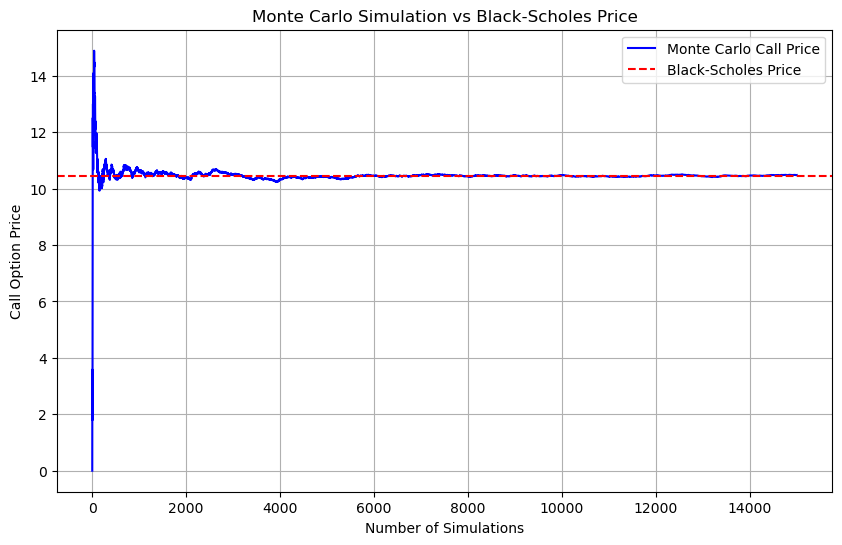

In [51]:
black_scholes_price = black_scholes(S0, K, r, sigma, T)
x_values, y_values = monte_carlo(S0, K, r, sigma, T)
monte_carlo_price = y_values[-1]
print(f"The Black-Scholes price of the call option is: {black_scholes_price:.5f}")
print(f"The Monte Carlo price of the call option is: {monte_carlo_price:.5f}")

percentage_difference = abs(black_scholes_price - monte_carlo_price) / black_scholes_price * 100
print(f"The percentage difference between Black-Scholes and Monte Carlo prices is: {percentage_difference:.5f}%")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Monte Carlo Call Price', color='blue')
plt.axhline(y=black_scholes_price, color='red', linestyle='--', label='Black-Scholes Price')
plt.title('Monte Carlo Simulation vs Black-Scholes Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid()
plt.show()